Given that we do not appear to have access to the Minerva sims, I'm going to compute covariances from the test boxes. I'm gonna start by computing a separate one for each HOD and Cosmology used, across realizations, and convince myself they don't vary much. 

In [15]:
from pearce.mocks.kittens import TestBox
from pearce.mocks import tpcf_subregions
from halotools.mock_observables import tpcf_jackknife
import numpy as np
from collections import OrderedDict
from time import time
from scipy.optimize import minimize_scalar
import yaml

In [2]:
import matplotlib
#matplotlib.use('Agg')
from matplotlib import pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set()

In [5]:
emu_config = '/home/users/swmclau2/scratch/xi_gg_zheng07_cosmo_v3/config.yaml'

In [6]:
with open(emu_config, 'r') as yamlfile:
    cfg = yaml.load(yamlfile)

In [8]:
cfg

{'HOD': {'fixed_nd': '5e-4',
  'min_ptcl': 100,
  'model': 'zheng07',
  'num_hods': 1000,
  'ordered_params': {'alpha': [0.7, 1.3],
   'logM0': [12.6, 13.6],
   'logM1': [13.7, 14.7],
   'logMmin': [12.0, 16.0],
   'sigma_logM': [0.05, 0.5]},
  'system': 'sherlock'},
 'computation': {'filename': '/home/users/swmclau2/scratch/xi_gg_zheng07_cosmo_v3/PearceXiggCosmo.hdf5',
  'max_time': 6,
  'n_jobs': 800,
  'overwrite': True,
  'queue_skipper': True,
  'system': 'sherlock'},
 'cosmology': {'boxno': '0:40',
  'particles': False,
  'scale_factors': 1.0,
  'simname': 'trainingbox',
  'system': 'sherlock'},
 'observation': {'bins': [0.07943282,
   0.11220185,
   0.15848932,
   0.22387211,
   0.31622777,
   0.44668359,
   0.63095734,
   0.89125094,
   1.25892541,
   1.77827941,
   2.51188643,
   3.54813389,
   5.01187234,
   7.07945784,
   10.0,
   14.12537545,
   19.95262315,
   28.18382931,
   39.81071706],
  'log_obs': True,
  'n_repops': 20,
  'obs': 'xi'}}

In [9]:
nd = cfg['HOD']['fixed_nd']
min_ptcl = cfg['HOD']['min_ptcl']
r_bins = np.array(cfg['observation']['bins'])
logMmin_bounds = cfg['HOD']['ordered_params']['logMmin']

In [10]:
hod_param_ranges =  cfg['HOD']['ordered_params']
del hod_param_ranges['logMmin']

In [11]:
def make_LHC(ordered_params, N, seed = None):

    if seed is None:
        seed = int(time())
    np.random.seed(seed)

    points = []
    # by linspacing each parameter and shuffling, I ensure there is only one point in each row, in each dimension.
    for plow, phigh in ordered_params.itervalues():
        point = np.linspace(plow, phigh, num=N)
        np.random.shuffle(point)  # makes the cube random.
        points.append(point)
    return np.stack(points).T

In [12]:
def add_logMmin(hod_params, cat):

    hod_params['logMmin'] = 13.0 #initial guess
    #cat.populate(hod_params) #may be overkill, but will ensure params are written everywhere
    def func(logMmin, hod_params):
        hod_params.update({'logMmin':logMmin}) 
        return (cat.calc_analytic_nd(hod_params) - nd)**2

    #res = minimize_scalar(func, bounds = logMmin_bounds, args = (hod_params,), options = {'maxiter':100}, method = 'Bounded')

    # assuming this doens't fail
    #print 'logMmin', res.x
    hod_params['logMmin'] = 15.0#res.x

In [13]:
N = 10
LHC = make_LHC(hod_param_ranges, N)
hod_dicts = [dict(zip(hod_param_ranges.keys(), vals)) for vals in LHC]

In [24]:
cov_mats = np.zeros((7,N, 5, 2*len(r_bins)-2, 2*len(r_bins)-2))

for boxno in xrange(7):
    for realization in xrange(5):
        print '*'*10
        cat = TestBox(boxno = boxno, realization = realization, system = 'sherlock')
        
        cat.load(1.0, HOD = str('zheng07'), particles = True, downsample_factor = 1e-2)
        
        for hod_idx, hod_params in enumerate(hod_dicts):
            print boxno, realization, hod_idx
            add_logMmin(hod_params, cat)
            cat.populate(hod_params)
            _, mat = cat.calc_xi(r_bins, do_jackknife=True, jk_args= {'n_rands':20, 'n_sub':5})
            cov_mats[boxno, hod_idx, realization] = mat


**********
0 0 0


ValueError: When calculating the two-point function, there was at least one 
separation bin with zero RR pairs. Since the ``Landy-Szalay`` estimator you chose 
divides by RR, you will have at least one NaN returned value.
Most likely, the innermost separation bin is the problem.
Try increasing the number of randoms and/or using broader bins.
To estimate the number of required randoms, the following expression 
for the expected number of pairs inside a sphere of radius ``r`` may be useful:

<Npairs> = (Nran_tot)*(4pi/3)*(r/Lbox)^3 



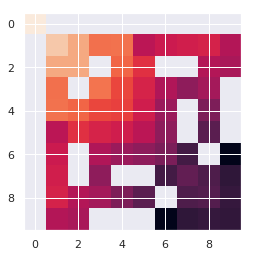

In [44]:
plt.imshow(np.log10(mat) )